In [452]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian

Labels Dataset

In [453]:
def f(x0, U, dt=.1):
    N = U.shape[0]

    x1 = np.empty(N+1)
    x2 = np.empty(N+1)
    x3 = np.empty(N+1)

    x1[0] = x0[0]
    x2[0] = x0[1]
    x3[0] = x0[2]

    for k, u in enumerate(U):
        x1[k+1] = x1[k] + u[0] * np.cos(x3[k]) * dt
        x2[k+1] = x2[k] + u[0] * np.sin(x3[k]) * dt
        x3[k+1] = x3[k] + u[1] * dt


    return np.array([x1, x2, x3])

def noisy (U, dt=.1):
    v = U[:, 0]
    omega = U[:, 1]

    N = U.shape[0]
    x = np.empty(N+1)

    x[1:] = (np.exp(v/6))* dt
    
    return x




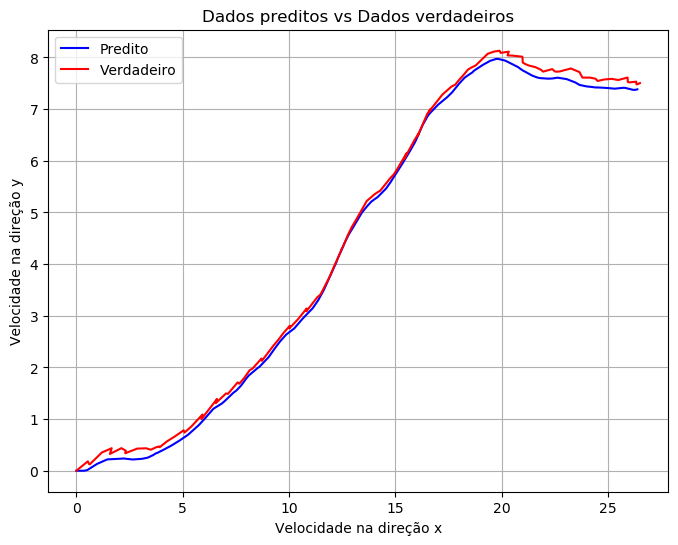

In [454]:
# Número de amostras
N_training = 100
N_validation = 20
N = N_training + N_validation

# Gerando dados de entrada aleatórios U
x0 = np.array([0.0, 0.0, 0.0])
U = torch.rand(N-1, 2)
U[:, 0] = U[:, 0] * 5.0  # Ajustando para o intervalo de 0 a 5
U[:, 1] = (U[:, 1] - 0.5) * 3.0  # Ajustando para o intervalo de -1.5 a 1.5


pred_x = f(x0, U).T

label_x = np.copy(pred_x)
noisy_x = noisy(U)

label_x[:, 0] += noisy_x
label_x[:, 1] += noisy_x

plt.figure(figsize=(8, 6))
plt.plot(pred_x[:, 0], pred_x[:, 1], 'b', label='Predito')
plt.plot(label_x[:, 0], label_x[:, 1], 'r', label='Verdadeiro')
plt.xlabel('Velocidade na direção x')
plt.ylabel('Velocidade na direção y')
plt.title('Dados preditos vs Dados verdadeiros')
plt.legend()
plt.grid(True)
plt.show()

In [455]:
# Training dataset
labels = label_x - pred_x
print(labels.shape)
print(U.shape)

indices = np.random.permutation(N-1)
trn_indices, val_indices = indices[:N_training], indices[N_training:]

Tdataset = ([torch.tensor(U[trn_indices], dtype=torch.float32), torch.tensor(labels[trn_indices], dtype=torch.float32)])

Vdataset = ([torch.tensor(U[val_indices], dtype=torch.float32), torch.tensor(labels[val_indices], dtype=torch.float32)])


(120, 3)
torch.Size([119, 2])


/tmp/ipykernel_21312/1794256986.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Tdataset = ([torch.tensor(U[trn_indices], dtype=torch.float32), torch.tensor(labels[trn_indices], dtype=torch.float32)])
/tmp/ipykernel_21312/1794256986.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Vdataset = ([torch.tensor(U[val_indices], dtype=torch.float32), torch.tensor(labels[val_indices], dtype=torch.float32)])


In [456]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x):
    return torch.norm(x, p=2, dim=-1)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()

rbf = RBFLayer(in_features_dim=2,
               num_kernels=5,
               out_features_dim=3,
               radial_function=rbf_gaussian,
               norm_function=euclidean_norm,
               normalization=True)


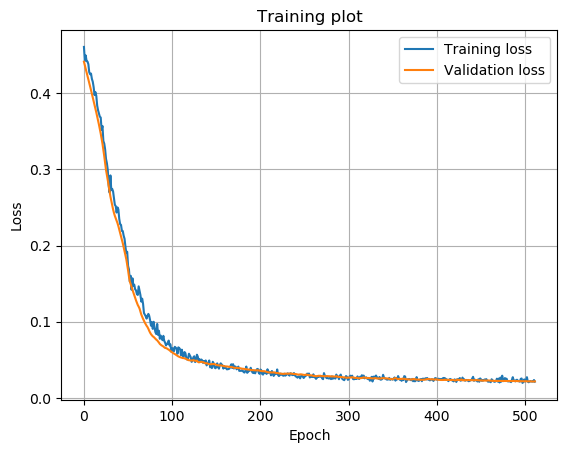

In [457]:
optimiser = torch.optim.Adam(rbf.parameters(), lr=1e-3)
loss_func = nn.L1Loss()

epoch = 0
batch_size = 32
trn_losses = []
val_losses = []

for epoch in range(512):
    indices = np.random.permutation(N_training)
    batch_idx = 0
    epoch_trn_losses = []
    epoch_val_losses = []
    
    # Epoch training
    while batch_idx < N_training:
        idxs = indices[batch_idx:batch_idx + batch_size]
        x = Tdataset[0][idxs]
        labels = Tdataset[1][idxs].flatten()
        
        # Compute loss
        optimiser.zero_grad()
        y = rbf(x)
        
        y = y.flatten()

        loss = loss_func(y, labels)
        epoch_trn_losses.append(loss.item())
        loss.backward()
        optimiser.step()
        batch_idx += batch_size
        
        with torch.no_grad():
            # Compute validation
            x = Vdataset[0]
            labels = Vdataset[1].flatten()
            y = rbf(x)
            y = y.flatten()
            loss = loss_func(y, labels)
            epoch_val_losses.append(loss.item())
            
    trn_losses.append(np.mean(epoch_trn_losses))
    val_losses.append(np.mean(epoch_val_losses))

plt.plot(trn_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Training plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

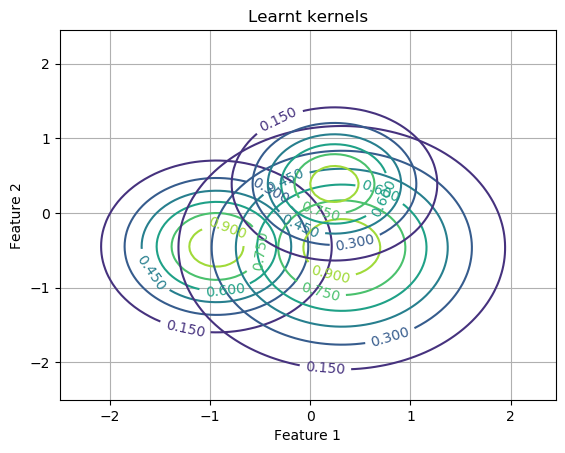

In [458]:
kernels = rbf.get_kernels_centers.numpy()
shapes = rbf.get_shapes.numpy()

def fun(x, y, center, shape):
    diff = center.T - [x, y]
    r = np.linalg.norm(diff, axis=0)
    return np.exp(-(shape * r) ** 2)

x = y = np.arange(-2.5, 2.5, 0.05)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

for i in range(3):
    center = kernels[i][:, None].repeat(10000, axis=1).T
    zs = np.array(fun(X.ravel(), Y.ravel(), center, shapes[i].repeat(10000)))
    Z = zs.reshape(X.shape)

    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Learnt kernels')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid()
plt.show()

(100, 3)
(99, 3)


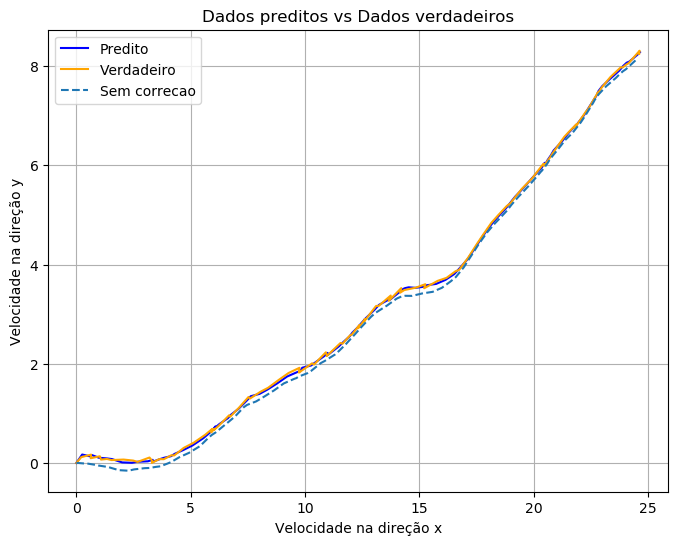

In [459]:
# Número de amostras
N = 100

# Gerando dados de entrada aleatórios U
x0 = np.array([0.0, 0.0, 0.0])
U = torch.rand(N-1, 2)
U[:, 0] = U[:, 0] * 5.0  # Ajustando para o intervalo de 0 a 5
U[:, 1] = (U[:, 1] - 0.5) * 3.0  # Ajustando para o intervalo de -1.5 a 1.5


nominal_value = f(x0, U).T

nn_value = f(x0, U).T
rbf_value = rbf(U).detach().numpy()

print(nn_value.shape)
print(rbf_value.shape)

nn_value[1:] += rbf_value


real_value = f(x0, U).T
noisy_x = noisy(U)
real_value[:, 0] += noisy_x
real_value[:, 1] += noisy_x

plt.figure(figsize=(8, 6))
plt.plot(nn_value[:, 0], nn_value[:, 1], 'b', label='Predito')
plt.plot(real_value[:, 0], real_value[:, 1], 'orange', label='Verdadeiro')
plt.plot(nominal_value[:, 0], nominal_value[:, 1], '--', label='Sem correcao')

plt.xlabel('Velocidade na direção x')
plt.ylabel('Velocidade na direção y')
plt.title('Dados preditos vs Dados verdadeiros')
plt.legend()
plt.grid(True)
plt.show()